In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [4]:
"""
def normalize_angle(phi):
    while (phi > math.pi):
        phi = phi - 2*math.pi
    while (phi < -math.pi):
        phi = phi + 2*math.pi
    return phi
"""

def normalize_angle(phi):
    return phi - 2*math.pi * math.floor((phi + math.pi) / (2*math.pi))

def sample_normal_distribution(b):
    return (b/6.0)*sum([random.uniform(-1, 1) for i in range(0, 12)])

def sample_triangular_distribution(b):
    return b * random.uniform(-1, 1) * random.uniform(-1, 1)

class MotionModel:
    def command(self, command):
        raise NotImplementedError

class OdometryMotionModel(MotionModel):
    def __init__(self, pose):
        self.pose = np.copy(pose)   
        
    @property
    def pose(self):
        return self.pose
    
    @pose.setter
    def pose(self, new_pose):
        self.pose = np.copy(new_pose)
    
    @pose.deleter
    def pose(self):
        self.pose = None
        del self.pose
        
    def command(self, command):
        rot1 = command[0]
        trans = command[1]
        rot2 = command[2]
        
        theta_old = normalize_angle(self.pose.item(2))
        
        update_vec = np.matrix([
            trans*math.cos(theta_old + rot1),
            trans*math.sin(theta_old + rot1),
            normalize_angle(rot1 + rot2)
        ]).T
        
        self.pose = self.pose + update_vec
        
        return self.pose 
    
    @staticmethod
    def command_static(pose, command):
        rot1 = command[0]
        trans = command[1]
        rot2 = command[2]
        
        theta_old = normalize_angle(pose.item(2))
        
        update_vec = np.matrix([
            trans*math.cos(theta_old + rot1),
            trans*math.sin(theta_old + rot1),
            normalize_angle(rot1 + rot2)
        ]).T
        
        return pose + update_vec
    
    @staticmethod
    def sample(pose, command, noise, sample=None):
        if not sample:
            raise ValueError("Provide a sampler")
        
        rot1 = command[0]
        trans = command[1]
        rot2 = command[2]
        
        a1, a2, a3, a4 = noise
        theta_old = normalize_angle(pose.item(2))
        
        rot1_h = rot1 - sample(a1*rot1 + a2*trans)
        trans_h = trans - sample(a3*trans + a4*(rot1+rot2))
        rot2_h = rot2 - sample(a1*rot2+a2*trans)
        
        update_vec = np.matrix([
            trans_h*math.cos(theta_old + rot1_h),
            trans_h*math.sin(theta_old + rot1_h),
            rot1_h + rot2_h
        ]).T
        
        return pose + update_vec

        
class BaseRobot:
    def __init__(self, x, y, theta, motion_model=None):
        self.pose = np.matrix([x, y, theta]).T
        self.motion = motion_model
    
    @property
    def pose(self):
        return self.pose
    
    @pose.setter
    def pose(self, new_pose):
        self.pose = np.copy(new_pose)
    
    @pose.deleter
    def pose(self):
        self.pose = None
        del self.pose
    
    @property
    def motion(self):
        return self.motion
    
    @motion.setter
    def motion(self, motion_model):
        self.motion = motion_model
    
    @motion.deleter
    def motion(self):
        del self.motion
        
    def motion_command(self, command):
        self.pose = self.motion.command(command)
        
class LandmarkMap:
    def __init__(self, landmarks):
        self.landmarks = {int(l[0]): tuple(l[1:]) for l in landmarks}
        
    def is_added(self, lid):
        return lid in self.landmarks.keys()
    
    def add(self, landmark):
        lid, lx, ly = landmark
        
        if not self.is_added(lid):
            self.landmarks[lid] = (lx, ly)
    
    def get(self, lid):
        if self.is_added(lid):
            return self.landmarks[lid]
    

In [5]:
def read_data(filename):
    odometry = []
    sensor = []
    
    with open(filename, 'r') as f:
        meas_pack = []
        for line in f:
            data = line.strip().split(" ")
            
            if data[0] == "ODOMETRY": 
                if len(meas_pack) != 0:
                    sensor.append(meas_pack)
                    meas_pack = []
                # rotation1, translation, rotation2
                data[1:] = [float(d) for d in data[1:]]
                odometry.append(tuple(data[1:]))
            elif data[0] == "SENSOR":
                # id of observed landmark
                data[1] = int(data[1])
                # range, bearing
                data[2:] = [float(d) for d in data[2:]]
                
                meas_pack.append(tuple(data[1:]))
    
    return odometry, sensor

In [6]:
def read_world(filename):
    landmarks = []
    
    with open(filename, 'r') as f:
        for line in f:
            data = line.strip().split(" ")
            data[0] = int(data[0])
            data[1:] = [float(d) for d in data[1:]]
            
            landmarks.append(tuple(data))
    
    return landmarks

In [7]:
class ParticleFilterMotionOnly:
    '''
        One particle contains pose information only
    '''
    def __init__(self, init_pose, motion_model=None, samples=500):
        self.samples = samples
        self.motion_model = motion_model
        self.init_pose = np.copy(init_pose)
        self.particles = []
    
    def step(self, command, noise, sampler):
        
        if len(self.particles) == 0:
            for i in range(0, self.samples):
                m = self.init_pose
                particle = motion_model.sample(m, command, noise, sampler)
                self.particles.append(particle)
            return self.particles
        
        new_particles = []
        for m in self.particles:
            particle = motion_model.sample(m, command, noise, sampler)
            new_particles.append(particle)
            
        self.particles = new_particles[:]
        return self.particles

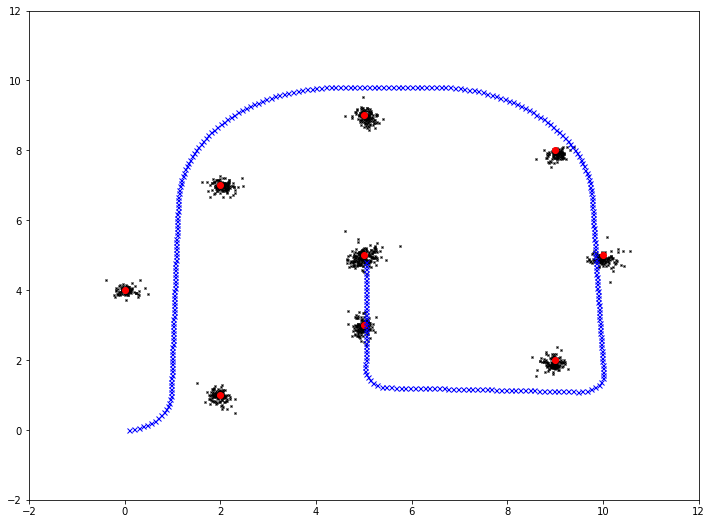

In [8]:
robot = BaseRobot(0, 0, 0)
motion_model = OdometryMotionModel(robot.pose)
robot.motion = motion_model

odometry, sensor = read_data('./data/simple/sensor_data.dat')
landmarks = read_world('./data/simple/world.dat')

landmark_map = LandmarkMap(landmarks)
commands = [np.array(odom).T for odom in odometry]

# Plot true robot path
x = []
y = []
meas_x = []
meas_y = []

plt.figure(figsize=(12, 9))
plt.xlim((-2, 12))
plt.ylim((-2, 12))

for key, value in landmark_map.landmarks.items():
    plt.plot(value[0], value[1], 'ro')

for command, readings in zip(commands, sensor):  
    robot.motion_command(command)
    
    rx = robot.pose.item(0)
    ry = robot.pose.item(1)
    rtheta = normalize_angle(robot.pose.item(2))
    
    for reading in readings:
        lid, srange, sbearing = reading
        
        olx = rx + srange * math.cos(sbearing + rtheta)
        oly = ry + srange * math.sin(sbearing + rtheta)
        
        meas_x.append(olx)
        meas_y.append(oly)
    
    x.append(rx)
    y.append(ry)
    
plt.plot(x, y, 'bx', markersize=5, zorder=2)
plt.plot(meas_x, meas_y, 'kx', markersize=2, zorder=1)

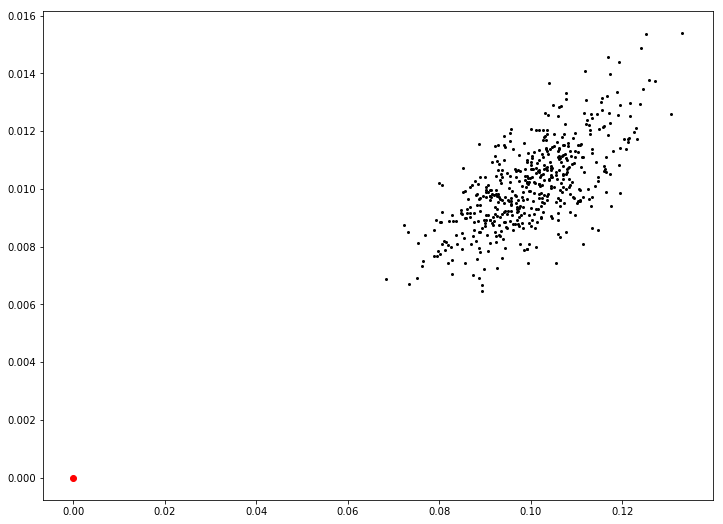

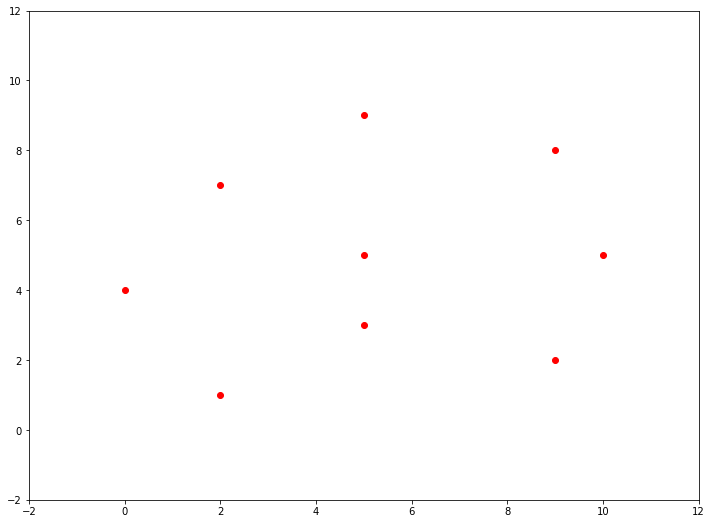

In [9]:
robot = BaseRobot(0, 0, 0)
motion_model = OdometryMotionModel(robot.pose)
robot.motion = motion_model

odometry, sensor = read_data('./data/simple/sensor_data.dat')
landmarks = read_world('./data/simple/world.dat')

landmark_map = LandmarkMap(landmarks)
commands = [np.array(odom).T for odom in odometry]

noise = [0.16, 0.16, 0.16, 0.16]

# Odometry model sampling example
x_sampled = []
y_sampled = []
samples = 500

plt.figure(figsize=(12, 9))
plt.plot(0, 0, 'ro')

pf_sampling = ParticleFilterMotionOnly(robot.pose, robot.motion, samples)
pf_particles = pf_sampling.step(commands[0], noise, sample_normal_distribution)

for sampled_pose in pf_particles:
    x_sampled.append(sampled_pose.item(0))
    y_sampled.append(sampled_pose.item(1))
    
plt.plot(x_sampled, y_sampled, 'ko', markersize=2)

# Plot true robot path and sampled approximations
x = []
y = []
particles_x = []
particles_y = []
particle_filter = ParticleFilterMotionOnly(robot.pose, robot.motion, samples=32)


fig, ax = plt.subplots(figsize=(12, 9))
ax.set_xlim((-2, 12))
ax.set_ylim((-2, 12))

ln, = ax.plot([], [], 'bx', markersize=5, zorder=2)
pn, = ax.plot([], [], 'ko', markersize=1, zorder=1)

for key, value in landmark_map.landmarks.items():
    plt.plot(value[0], value[1], 'ro')
    
def init():
    ln.set_data([], []);
    return ln,

def update(frame):
    particles = particle_filter.step(frame, noise, sample_normal_distribution)
    
    for particle in particles:
        particles_x.append(particle.item(0))
        particles_y.append(particle.item(1))
    
    robot.motion_command(frame)
    
    x.append(robot.pose.item(0))
    y.append(robot.pose.item(1))
    
    ln.set_data(x, y)
    pn.set_data(particles_x, particles_y)
    
    return ln, pn,

ani = FuncAnimation(fig, update, frames=commands, init_func=init, blit=True, interval=100)
#HTML(ani.to_html5_video())

In [10]:
class EKFLocalization:
    def __init__(self, pose, motion_model=None):
        # Main estimate
        self.mean = np.copy(pose)
        self.cov = np.zeros((self.mean.size, self.mean.size))
        
        # Intermediate variables
        self._mean = np.copy(self.mean)
        self._cov = np.copy(self.cov)
        
        self.motion_model = motion_model
    
    def predict(self, command):
        self._mean = self.motion_model.command_static(self.mean, command)
        
        # TODO: Put in motion model
        theta_n = normalize_angle(self.mean.item(2))
        rot1, trans, rot2 = command
        
        ang = normalize_angle(theta_n + rot1)
        Gt = np.matrix([
            [1, 0, -trans*math.sin(ang)],
            [0, 1, trans*math.cos(ang)],
            [0, 0, 1],
            
        ])
        
        # TODO: motion noise
        Rt = np.matrix([
            [0.1, 0, 0],
            [0, 0.1, 0],
            [0, 0, 0.01]
        ])
        
        self._cov = Gt * self.cov * Gt.T + Rt
        
        return self._mean, self._cov
    
    def correct(self, measurements, local_map):
        # TODO: measurement noise
        Qt = np.eye(self._mean.size-1) * 0.01
        
        rx = self._mean.item(0)
        ry = self._mean.item(1)
        rtheta = normalize_angle(self._mean.item(2))
        
        for reading in measurements:
            # TODO: Put in measurement model
            lid, srange, sbearing = reading
            
            z_measured = np.matrix([srange, normalize_angle(sbearing)]).T
            
            # Expected observation
            lx, ly = local_map.get(lid)
            dx = lx - rx
            dy = ly - ry
            delta = np.matrix([dx, dy]).T
            q = delta.T * delta
            z_expected = np.matrix([
                math.sqrt(q), 
                normalize_angle(np.arctan2(dy, dx) - rtheta)
            ]).T
            # Jacobian
            Ht = np.matrix([
                [-math.sqrt(q)*dx, -math.sqrt(q)*dy , 0],
                [dy, -dx, -q]
            ])
            Ht = np.multiply((1.0 / q), Ht)
            
            Kgain = self._cov * Ht.T * np.linalg.inv(Ht*self._cov*Ht.T + Qt)
            self._mean = self._mean + Kgain*(z_measured - z_expected)
            self._cov = (np.eye(self._mean.size) - Kgain*Ht) * self._cov
        
        self.mean = np.copy(self._mean)
        self.cov = np.copy(self._cov)
        
        return self.mean, self.cov
        

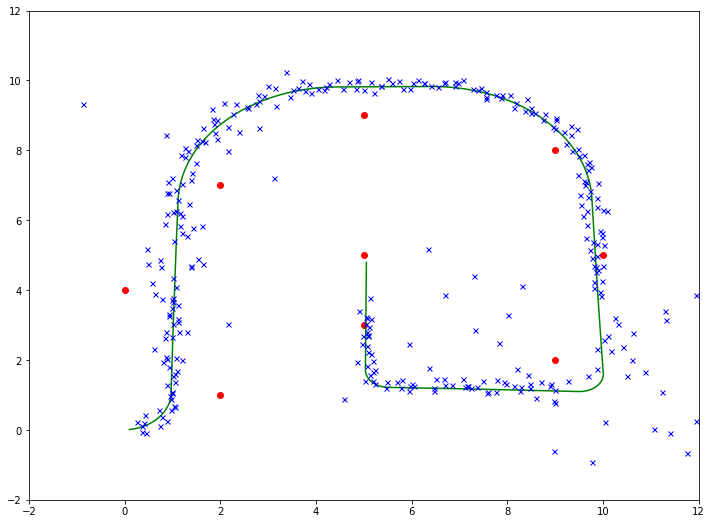

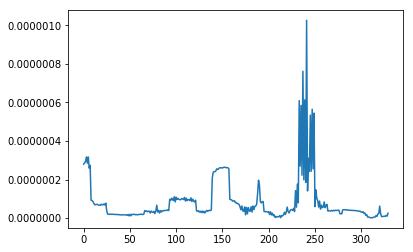

In [11]:
robot = BaseRobot(0, 0, 0)
motion_model = OdometryMotionModel(robot.pose)
robot.motion = motion_model

odometry, sensor = read_data('./data/simple/sensor_data.dat')
landmarks = read_world('./data/simple/world.dat')

landmark_map = LandmarkMap(landmarks)
commands = [np.array(odom).T for odom in odometry]

EKF = EKFLocalization(robot.pose, motion_model)

# Plot true robot path
x = []
y = []
EKF_x = []
EKF_y = []
cov_dets = []

plt.figure(figsize=(12, 9))
plt.xlim((-2, 12))
plt.ylim((-2, 12))

for key, value in landmark_map.landmarks.items():
    plt.plot(value[0], value[1], 'ro', zorder=0)

for command, readings in zip(commands, sensor):  
    # True path
    robot.motion_command(command)
    x.append(robot.pose.item(0))
    y.append(robot.pose.item(1))
    
    EKF.predict(command)
    EKF.correct(readings, landmark_map)
    
    EKF_x.append(EKF.mean.item(0))
    EKF_y.append(EKF.mean.item(1))
    cov_dets.append(np.linalg.det(EKF.cov))
    
plt.plot(x, y, 'g', zorder=1)    
plt.plot(EKF_x, EKF_y, 'bx', markersize=5, zorder=2)
#plt.plot(meas_x, meas_y, 'kx', markersize=2)
plt.figure()
plt.plot(cov_dets)

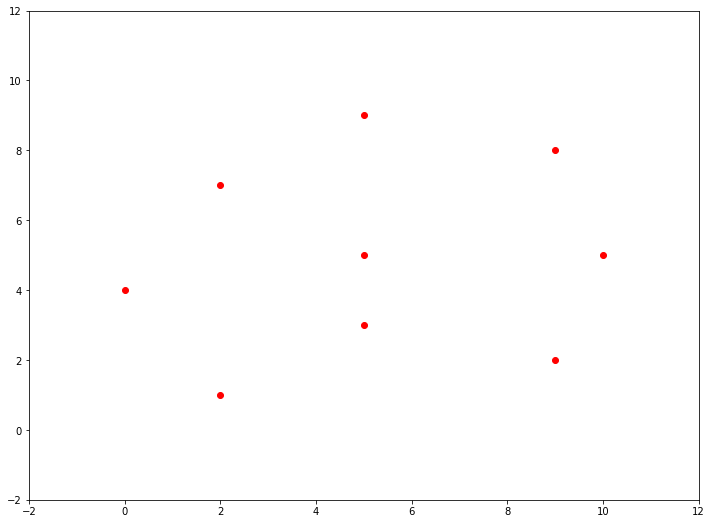

In [12]:
robot = BaseRobot(0, 0, 0)
motion_model = OdometryMotionModel(robot.pose)
robot.motion = motion_model

odometry, sensor = read_data('./data/simple/sensor_data.dat')
landmarks = read_world('./data/simple/world.dat')

landmark_map = LandmarkMap(landmarks)
commands = [np.array(odom).T for odom in odometry]

EKF = EKFLocalization(robot.pose, motion_model)

# Plot true robot path
x = []
y = []
EKF_x = []
EKF_y = []
cov_dets = []

fig, ax = plt.subplots(figsize=(12, 9))
ax.set_xlim((-2, 12))
ax.set_ylim((-2, 12))

ln, = ax.plot([], [], 'g', zorder=2)
pn, = ax.plot([], [], 'bx', markersize=5, zorder=1)
sline, = ax.plot([], [], 'k')

for key, value in landmark_map.landmarks.items():
    plt.plot(value[0], value[1], 'ro', zorder=0)
    
    
def init():
    ln.set_data([], []);
    sline.set_data([], []);
    return ln,

def update(frame):
    command, readings = frame
    
    # True path
    robot.motion_command(command)
    x.append(robot.pose.item(0))
    y.append(robot.pose.item(1))
    
    EKF.predict(command)
    
    rx = EKF._mean.item(0)
    ry = EKF._mean.item(1)
    rtheta = normalize_angle(EKF._mean.item(2))
    
    for reading in readings:
        lid, srange, sbearing = reading
        
        ang = normalize_angle(sbearing + rtheta)
        olx = rx + srange * math.cos(ang)
        oly = ry + srange * math.sin(ang)
        
        sline.set_data([rx, olx], [ry, oly])
    
    EKF.correct(readings, landmark_map)
    
    EKF_x.append(EKF.mean.item(0))
    EKF_y.append(EKF.mean.item(1))
    cov_dets.append(np.linalg.det(EKF.cov))
    
    ln.set_data(x, y)
    pn.set_data(EKF_x, EKF_y)
    
    return ln, pn, sline,

ani = FuncAnimation(fig, update, frames=zip(commands, sensor), init_func=init, blit=True, interval=200)

In [13]:
HTML(ani.to_html5_video())